<a href="https://colab.research.google.com/github/Anggunasr/MSBA2425/blob/ADA/7_1_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
This tutorial will start by walking through a custom-built CNN in PyTorch. We will be working with a chest x-ray set from Kaggle ([here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)) where we are predicting whether a paitent has pneumonia or not.

To get the data we need an API key from Kaggle. Set up an account (if you haven't got one already) and then click on your avatar in the top right and "Account" from the dropdown menu. Scroll down the page and you'll find a button to "Create New API Token". This downloads an API key to your PC which you can upload here.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anggunasr","key":"13d6d487de22430d781618afcc2dcd9d"}'}

Next we need to move this to a folder called kaggle as this is where Colab will look (Linux commands):

In [2]:
!mkdir -p ~/.kaggle # make dir
!cp kaggle.json ~/.kaggle/ #copy the data
!chmod 600 /root/.kaggle/kaggle.json # make the folder can be accessed

## Data Extraction
Now you can download the data. The following can be used for any Kaggle dataset. When you are on the dataset page click the three vertical dots on the right and select "Copy API command". This gives you code that looks like below (but add a "!" at the start):

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia # downloading the data from kaggle

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:43<00:00, 22.8MB/s]
100% 2.29G/2.29G [01:43<00:00, 23.7MB/s]


This has added the data as a zip folder. We can unzip it and create a new folder (Linux again):

In [4]:
!unzip -q chest-xray-pneumonia.zip -d chest-xray-pneumonia

For ease we will create some variables to store the path to the directories:

In [5]:
train_dir = "/content/chest-xray-pneumonia/chest_xray/train"
test_dir = "/content/chest-xray-pneumonia/chest_xray/test"
val_dir = "/content/chest-xray-pneumonia/chest_xray/val"

## Data Augmentations
Now we can add a generator to create augmentations.

For test and validation we just want to normalise (we use the standard ImageNet numbers for this). For the training you have some additional choices! Which of the augmentations would be appropriate for our problem? What values should you choose if so? These are ultimately domain questions we need to consider,

In [6]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define data transformations
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(224), # Randomly crop and resize
    #transforms.RandomHorizontalFlip(),  # Example augmentation
    #transforms.RandomVerticalFlip(),  # Example augmentation
    #transforms.RandomRotation(n),  # Example augmentation change n to max degrees you want to rotate
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random color adjustments

    # keep these ones in!
    transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((32, 32)),  # Resize images (adjust size as needed)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets and apply transfomrations
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create data loaders
batch_size = 128  # Adjust batch size as needed (hyperparameter!)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Convolutional Neural Network
Now we can build our model:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3) # conv layer with 16 3x3 filters, 3 because we use RGB, the total 3x3 is based on the user, could be better or worse, need to be tried
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # maxpool to 2x2 filters, pad with o
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3) # conv layer with 16 3x3 filters -- 16 in input is from the previous result which is 16
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # maxpool to 2x2 filters, pad with o
        self.flatten = nn.Flatten() # flatten layer
        self.fc1 = nn.Linear(576, 24) # linear layer with 24 neurons
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(24, 1) # binary classification so 1x neuron

    def forward(self, x):
        x = F.relu(self.conv1(x)) # convolution with ReLU
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.flatten(x) # Use flatten layer
        x = F.relu(self.fc1(x)) # linear layer with ReLU
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)) # Sigmoid for binary classification
        return x

cnn = PneumoniaCNN()
cnn

PneumoniaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=576, out_features=24, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=24, out_features=1, bias=True)
)

To complete our model let's specify the loss function and optimiser:

In [8]:
# Define loss function and optimizer
import torch.optim as optim

criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
optimiser = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=0.0005) # Adam optimizer the decay is used because each epoch will be less learning
# we add a weight decay parameter to reduce the learning rate each epoch

Let's see how many parameters this is:

In [9]:
# Move model to device
from torchsummary import summary

# Move data to GPU to get summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

summary(cnn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
       BatchNorm2d-2           [-1, 16, 30, 30]              32
         MaxPool2d-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 16, 13, 13]           2,320
       BatchNorm2d-5           [-1, 16, 13, 13]              32
         MaxPool2d-6             [-1, 16, 6, 6]               0
           Flatten-7                  [-1, 576]               0
            Linear-8                   [-1, 24]          13,848
           Dropout-9                   [-1, 24]               0
           Linear-10                    [-1, 1]              25
Total params: 16,705
Trainable params: 16,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 0.06
Estimated Tot

~17,000 parameters to learn! We better get busy:

In [12]:
# Early stopping parameters
patience = 5 # how many times we accept no improvement in val performance before early stopping
best_val_loss = float('inf') # keep track of the best loss value
epochs_no_improve = 0 # start the count at 0

# empty lists to store losses for visualisation
train_losses = []
val_losses = []

# Training loop
num_epochs = 5  # Arbitrarily high number - early stopping will end before this

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # add images and label in batch to the GPU
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float and add dimension
        cnn = cnn.to(device) # Pass model as well

        # print to check model is using GPU
        #print(f"Is model in GPU during loop : {next(cnn.parameters()).is_cuda}")

        optimiser.zero_grad() # reset the optimiser

        # run the images through the model
        outputs = cnn(images)
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backpropogate
        optimiser.step() # update parameters
        running_loss += loss.item() # keep track of loss for visualisation

    # store losses for visualisation
    train_losses.append(running_loss/len(train_loader)) # average loss

    # Validation
    cnn.eval()
    val_loss = 0.0
    all_preds = [] # holder for predictions as 0 or 1
    all_labels = [] # compare with labels
    with torch.no_grad(): # not update/backpropogation
      for images, labels in val_loader:
          # add images and label in batch to the GPU
          images = images.to(device)
          labels = labels.to(device).float().unsqueeze(1)
          cnn = cnn.to(device) # Pass model as well

          # run the images through the model
          outputs = cnn(images)
          loss = criterion(outputs, labels) # calculate loss
          val_loss += loss.item() # keep track of loss for visualisation

    # store losses and recall for visualisation
    val_losses.append(val_loss/len(val_loader)) # average loss

    # Early stopping
    if val_loss < best_val_loss: # is this better than previous record
        best_val_loss = val_loss # if so set as new best
        epochs_no_improve = 0 # make the no improve counter zero again
    else:
        epochs_no_improve += 1 # otherwise increase the count by one

    train_loss_rnd = round(running_loss / len(train_loader), 4)
    val_loss_rnd = round(val_loss / len(val_loader), 4)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss_rnd}, Validation Loss: {val_loss_rnd}")


    if epochs_no_improve == patience: # if epochs without improvement is at the patience level
        print("Early stopping triggered.")
        break # end the training


Epoch [1/5], Training Loss: 0.0998, Validation Loss: 0.7347
Epoch [2/5], Training Loss: 0.0804, Validation Loss: 0.2444
Epoch [3/5], Training Loss: 0.0658, Validation Loss: 0.4043
Epoch [4/5], Training Loss: 0.0608, Validation Loss: 0.2382
Epoch [5/5], Training Loss: 0.0624, Validation Loss: 0.2217


## Results
Let's visualise the results:

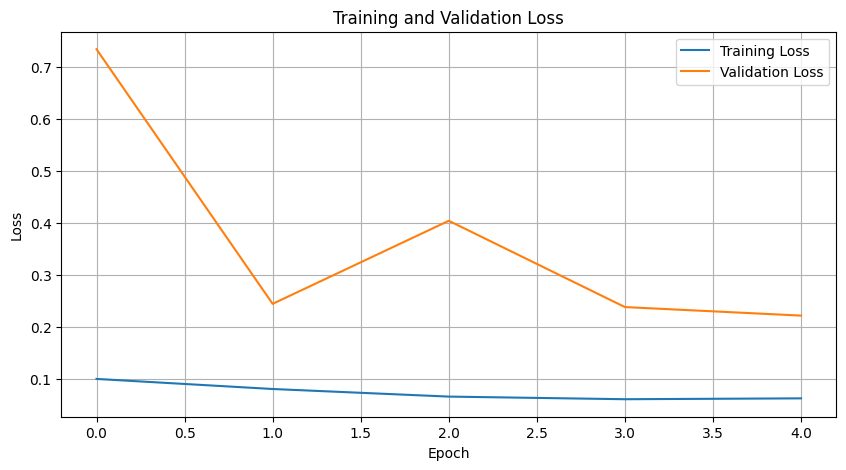

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Overfitting in training & validation loss:
if the training is having good graph in the running epoch but jumping around. However, if the validation jumping around but still shows similar direction as the training (no continuous decrease then continous increase). Also, it might be because to number of validation set is "that" low

We can see loss on the training set has steadily improved. On the validation set its a bit more "bouncey" but then that's not a big set of images. Let's see how we do on test:

In [14]:
# Evaluation on the test set
from sklearn.metrics import recall_score

cnn.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted_labels = (outputs > 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

test_loss_rnd = round(test_loss / len(test_loader), 4)
test_recall = round(recall_score(labels.cpu(), predicted_labels.cpu()), 4)

print(f"Test Loss: {test_loss_rnd}")
print(f"Test Recall: {test_recall}")

Test Loss: 0.5972
Test Recall: 0.9821


100% recall and relatively small loss (cross entropy). Our model seems to do pretty well ... but, would it be better if we tried augmentations?